# CNN for Particle Classification

In this notebook, we train 10 layers deep CNN for particle type classification ($e^-$, $\mu^-$, and $\gamma$) using the workshop dataset.

In [1]:
from __future__ import print_function
from IPython.display import display
import torch, time
import numpy as np

## Defining a network
Let's define our network. The design below consists of 7 convolution layers + 3 fully-connected layers (10 learnable layers). Here is a summary of the graph operations.
* Feature extractor:
    1. Input shape: (N,88,168,2) ... N samples of 88x168 2D images with 2 channels
    2. Convolution layer + ReLU, 16 filters, kernel size 3x3, stride 1 (default)
    3. 2D max-pooling, kernel size 2, stride 2
    4. 2x Convolution layer + ReLU, 32 filters, kernel size 3x3, stride 1 (default)
    5. 2D max-pooling, kernel size 2, stride 2
    6. 2x Convolution layer + ReLU, 64 filters, kernel size 3x3, stride 1 (default)
    7. 2D max-pooling, kernel size 2, stride 2
    8. 2x Convolution layer + ReLU, 128 filters, kernel size 3x3, stride 1 (default)
* Flattening
    9. 2D average-pooling, kernel size = 2D image spatial dimension at this point (results in length 128 1D array)
* Classifier:
    10. Fully-connected layer + ReLU, 128 filters
    11. Fully-connected layer + ReLU, 128 filters
    12. Fully-connected layer, M filters where M = number of classification categories

In [2]:
class CNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            torch.nn.Conv2d(2,16,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(16,32,3), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))


## Defining a train loop
For convenience, define a _BLOB_ class to keep objects together. To a BLOB instance, we attach LeNet, our loss function (`nn.CrossEntropyLoss`), and Adam optimizer algorithm. For analysis purpose, we also include `nn.Softmax`. Finally, we attach data and label place holders.

In [3]:
class BLOB:
    pass
blob=BLOB()
blob.net       = CNN().cuda() # construct Lenet, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

We define 2 functions to be called in the training loop: forward and backward. These functions implement the evaluation of the results, error (loss) definition, and propagation of errors (gradients) back to update the network parameters.

In [4]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())        
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()


## Running a train loop 

Finally, we're ready to run the training! But before that, we define a `IterationLog` class, which is simply a train log holder to analyze the results later.

In [5]:
class IterationLog:
    def __init__(self):
        self.iteration=[]
        self.epoch=[]
        self.loss=[]
        self.accuracy=[]
    def append(self,iteration,epoch,res):
        self.iteration.append(int(iteration))
        self.epoch.append(float(epoch))
        self.loss.append(res['loss'])
        self.accuracy.append(res['accuracy'])

Now we are ready for training! Let's create a dataloader, write a loop to  call forward and backward.

In [6]:
# Define batch size
BATCH_SIZE=64
# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=3

# Create data loader
from iotools import loader_factory
# for train
train_loader=loader_factory('H5Dataset', batch_size=BATCH_SIZE, shuffle=True, num_workers=4, data_dirs=['iotools'], flavour='.h5')
# for validation
test_loader=loader_factory('H5Dataset', batch_size=100, shuffle=True, num_workers=1, data_dirs=['iotools'], flavour='.h5')

# Set the network to training mode
blob.net.train()
# Train log
train_log,test_log=IterationLog(),IterationLog()
epoch=0.
iteration=0
# Start training
while epoch < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    from utils import progress_bar
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # data and label
        blob.data, blob.label, index = data
        # call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
            train_log.append((i+1),epoch,res)
        # more rarely, run validation
        if (i+1)%200 == 0:
            with torch.no_grad():
                blob.net.eval()
                blob.data,blob.label,index = next(iter(test_loader))
                test_log.append((i+1),epoch,forward(blob,False))
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
        # Reset time counter to measure the data streaming wait-time for the next iteration
        iotime=time.time()


Epoch 0 Starting @ 2019-04-05 12:05:49


Epoch 0 Starting @ 2019-04-05 12:09:32


Epoch 1 Starting @ 2019-04-05 12:13:18


## Inspecting the training process
Let's plot the traing log for both train and test set.

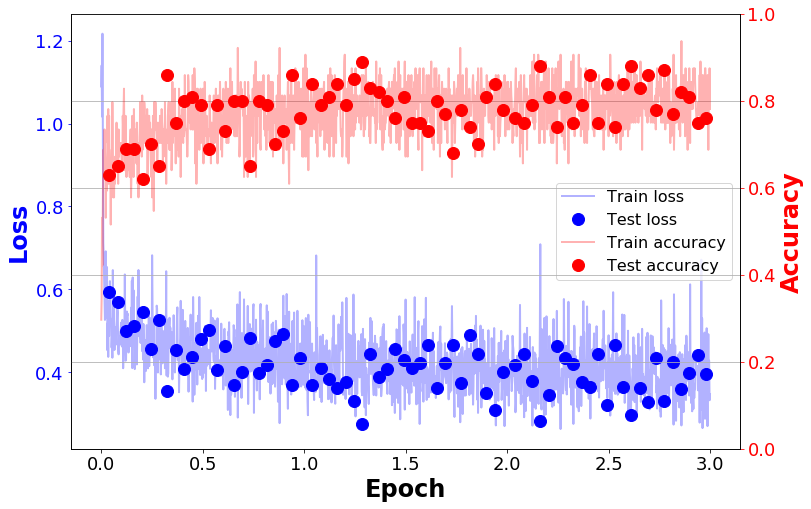

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

#         marker='o',linestyle='',
#         color='orange',label='Acc. Nonzero Px')
#ax2.plot(log.test_steps,1.- np.array(log.test_acc_all),color='magenta',label='Acc. All px')
ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these three lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

We see the loss is coming down while the accuracy is increasing. These two should be anti-correlated, so this is expected. We also see the network performance on the test dataset (circles) follow those of train dataset (lines). This means there is no apparent overtraining.

**Question: is the network still learning?**
Both the loss and accuracy curve have large fluctuations and it is somewhat hard to see if the values are still changing. Let's plot the moving average of the loss and accuracy values.

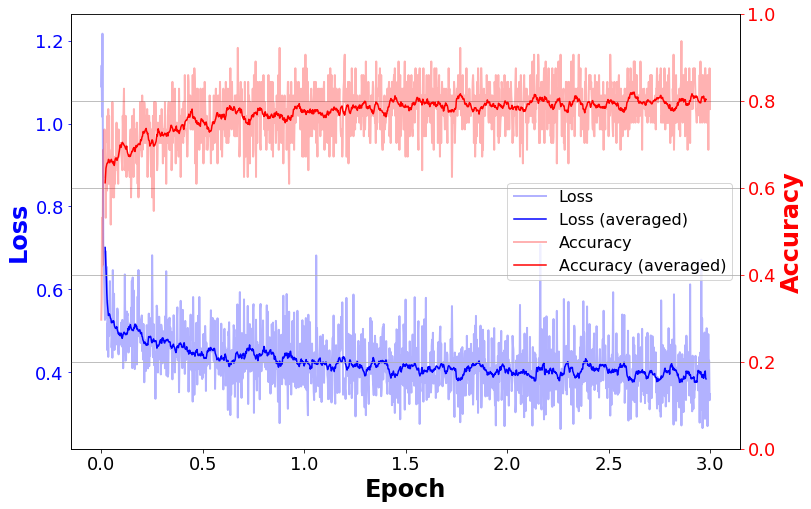

In [10]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

#         marker='o',linestyle='',
#         color='orange',label='Acc. Nonzero Px')
#ax2.plot(log.test_steps,1.- np.array(log.test_acc_all),color='magenta',label='Acc. All px')
ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these three lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()


The tick lines now represent the moving average (all data points are from the train log). It appears the network is still learning. We can train for a longer period to achieve a better accuracy.

## Performance Analysis
Beyond looking at the performance of the network, we can analyze how the network is performing for each classification target. Let's first obtain a high-statistics analysis output by running the network on all test samples.